In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [13]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=lambda x: [word_pos[0] for word_pos in eval(x)],
                                   lowercase=False,
                                   stop_words=None)

def tfidf_vectorize(data, column):
    tfidf_vectors = tfidf_vectorizer.fit_transform(data[column])

    return tfidf_vectors

In [14]:
def train_model(X, y, num_classes):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    histories = []
    models = []

    for fold, (train_indices, val_indices) in enumerate(kfold.split(X, y)):
        X_train, y_train = X[train_indices], y[train_indices]
        X_val, y_val = X[val_indices], y[val_indices]

        model = keras.Sequential([
            keras.layers.Dense(units=num_classes, activation='softmax', input_shape=(X.shape[1],))
        ])

        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

        models.append(model)
        histories.append(history)
        
    return models, histories

In [15]:
df = pd.read_csv("\625.742-Theory-of-Machine-Learning\\News Category Dataset Cleaned 20230416.csv")

In [16]:
categories = ['WELLNESS & HEALTH','ENTERTAINMENT','TRAVEL', 'STYLE & BEAUTY', 'PARENTING', 'QUEER VOICES', 'FOOD & DRINK']
data = df[df['category'].isin(categories)]

sampled_data = data.groupby('category', group_keys=False).apply(lambda x: x.sample(n=3000))

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(sampled_data['category'])

X_sparse = tfidf_vectorize(sampled_data, 'wordnet_pos_desc')

In [17]:
X_train_sparse, X_val_sparse, y_train, y_val = train_test_split(X_sparse, y, test_size=0.2, random_state=12)

X = X_train_sparse.toarray()

num_classes = len(label_encoder.classes_)
y_onehot = keras.utils.to_categorical(y_train, num_classes)

In [18]:
models, histories = train_model(X, y_onehot, num_classes)

Train on 13440 samples, validate on 3360 samples
Epoch 1/10
13440/13440 [==============================] - 4s 333us/sample - loss: 1.9034 - accuracy: 0.4725 - val_loss: 1.8620 - val_accuracy: 0.5631
Epoch 2/10
13440/13440 [==============================] - 4s 295us/sample - loss: 1.7834 - accuracy: 0.7493 - val_loss: 1.7859 - val_accuracy: 0.6080
Epoch 3/10
13440/13440 [==============================] - 4s 290us/sample - loss: 1.6717 - accuracy: 0.7988 - val_loss: 1.7173 - val_accuracy: 0.6190
Epoch 4/10
13440/13440 [==============================] - 4s 289us/sample - loss: 1.5689 - accuracy: 0.8202 - val_loss: 1.6556 - val_accuracy: 0.6214
Epoch 5/10
13440/13440 [==============================] - 4s 316us/sample - loss: 1.4746 - accuracy: 0.8312 - val_loss: 1.6002 - val_accuracy: 0.6223
Epoch 6/10
13440/13440 [==============================] - 4s 293us/sample - loss: 1.3882 - accuracy: 0.8367 - val_loss: 1.5499 - val_accuracy: 0.6256
Epoch 7/10
13440/13440 [===========================

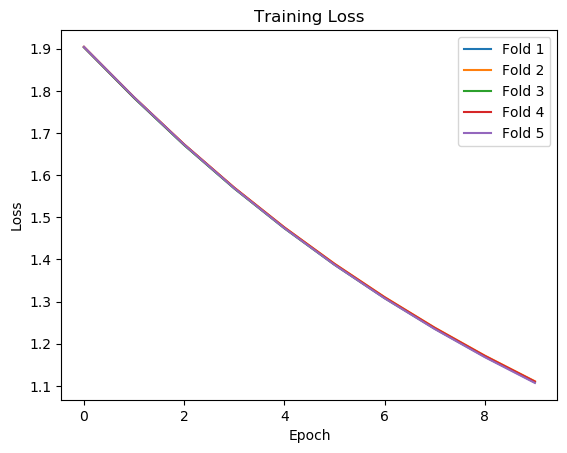

In [19]:
for fold, history in enumerate(histories):
    plt.plot(history.history['loss'], label=f"Fold {fold + 1}")
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
loss_avg = []
acc_avg = []
X_val = X_val_sparse.toarray()
y_onehot_val = keras.utils.to_categorical(y_val, num_classes)
for model in models:
    loss, accuracy = model.evaluate(X_val, y_onehot_val)
    loss_avg.append(loss)
    acc_avg.append(accuracy)
    
print('Test loss:', sum(loss_avg)/len(loss_avg))
print('Test accuracy:', sum(acc_avg)/len(acc_avg))

4200/4200 [==============================] - 1s 185us/sample - loss: 1.3964 - accuracy: 0.6305
Test loss: 1.3970149636041551
Test accuracy: 0.632619047164917
